## **Dataset Cleaning and Face Image Extraction**



***Import Modules***

In [ ]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt

***Mouting Google Drive***

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


***Location of Harr Cascade Files for Frontal Face and Eye Detection***

In [ ]:
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Colab Notebooks/haar-cascade-files-master/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Colab Notebooks/haar-cascade-files-master/haarcascade_eye.xml')

***Function for Extracting Multiple Faces on an Image***

In [ ]:
def getCroppedFaceImage(image_path):
  img = cv2.imread(image_path)
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray,1.3,5)
  
  if len(faces) == 0:
    return None
  else:
    faces_list = []
    for face in faces:
      for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h,x:x+w]
        roi_color = img[y:y+h,x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        faces_list.append(roi_color)
      return faces_list

***Scan and Make Directories according to Emotion Dataset***

In [ ]:
path_to_data = "/content/drive/MyDrive/Colab Notebooks/emotions_dataset_v0.1/"
path_to_cr_data = "/content/drive/MyDrive/Colab Notebooks/emotions_dataset_v0.1/cropped/"

In [ ]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [ ]:
img_dirs

In [ ]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

***Extracting and Saving Face Images for each Emotion Type***

In [ ]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = getCroppedFaceImage(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            for f in roi_color:
              cropped_file_name = celebrity_name + str(count) + ".jpg"
              cropped_file_path = cropped_folder + "/" + cropped_file_name 
              cv2.imwrite(cropped_file_path, f)
              celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
              count += 1 

## **Convolutional Neural Network Building for Training and Testing Dataset**

***Importing Modules***

In [ ]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from torch.utils.tensorboard import SummaryWriter

***Checking for GPU availability***

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


***Adding Transformation on Training Images***

In [ ]:
transformer = transforms.Compose([
                                  transforms.RandomPerspective(distortion_scale=0.6,p=0.5), transforms.RandomRotation(degrees=(0,180)),
                                  transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)), transforms.RandomInvert(p=0.2),
                                  transforms.RandomAdjustSharpness(0, p=0.25), transforms.RandomAdjustSharpness(2, p=0.25),
                                  transforms.RandomAutocontrast(p=0.2), transforms.RandomEqualize(p=0.1),
                                  transforms.Resize((150,150)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5,0.5,0.5], 
                                                        [0.5,0.5,0.5])
])

***Dataloader***

In [ ]:
train_path = "/content/drive/MyDrive/Colab Notebooks/new_clean_emotions_dataset_v0.1/train/"
test_path = "/content/drive/MyDrive/Colab Notebooks/new_clean_emotions_dataset_v0.1/train/"

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=32, shuffle=True
)

test_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size = 32, shuffle = True
)

In [ ]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [ ]:
classes

['angry',
 'confused',
 'crying',
 'fear',
 'happy',
 'puzzled',
 'sad',
 'scared',
 'shy']

***Convolutional Neural Network***

In [ ]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=9):
        super(ConvNet,self).__init__()
        
        #Input Shape = (32,3,150,150)
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        
        self.pool=nn.MaxPool2d(kernel_size=2) #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()          
                
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32) 
        self.relu3=nn.ReLU() 
                
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
               
        output=output.view(-1,32*75*75)
        output=self.fc(output)
      
        return output

In [ ]:
net=ConvNet(num_classes=9)
model = net

***Parameters***

In [ ]:
optimizer = Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
num_epochs = 10
writer = SummaryWriter('runs/fer2013_experiment_1')
criterion= nn.CrossEntropyLoss()

In [ ]:
train_count = len(glob.glob(train_path+'/**/*.jpg'))
test_count = len(glob.glob(test_path+'/**/*.jpg'))
print(train_count,test_count)
train_dataset = train_count
validation_dataset = test_count

1354 1354


***Model Traing and Evaluation Function***

In [ ]:
def Train(epochs,train_loader,val_loader,criterion,optmizer,device, writer):
    '''
    Training Loop
    '''
    best_accuracy = 0
    print("===================================Start Training===================================")
    for e in range(epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0
        # Train the model  #
        net.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            try:
              optmizer.zero_grad()
            except Exception:
              pass
            
            outputs = net(data)
            
            loss = criterion(outputs,labels)
            loss.backward()
            optmizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs,1)
            train_correct += torch.sum(preds == labels.data)

        #validate the model#
        net.eval()
        for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)
            val_loss = criterion(val_outputs, labels)
            validation_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data)

        train_loss = train_loss/train_dataset
        train_acc = train_correct.double() /train_dataset
        validation_loss =  validation_loss /validation_dataset
        val_acc = val_correct.double() /validation_dataset
        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.3f}% \tValidation Acuuarcy {:.3f}%'
                                                           .format(e+1, train_loss,validation_loss,train_acc * 100, val_acc*100))
        
        if val_acc>best_accuracy:
          torch.save(net.state_dict(),'/content/drive/MyDrive/Colab Notebooks/best_checkpoint_test.model')
          best_accuracy=val_acc

In [ ]:
Train(num_epochs,train_loader,test_loader,criterion,optimizer,device,writer)

===================================Start Training===================================
Epoch: 1 	Training Loss: 0.03233056 	Validation Loss 0.02582853 	Training Acuuarcy 76.809% 	Validation Acuuarcy 80.724%
Epoch: 2 	Training Loss: 0.02915660 	Validation Loss 0.02586996 	Training Acuuarcy 80.428% 	Validation Acuuarcy 80.724%
Epoch: 3 	Training Loss: 0.02806220 	Validation Loss 0.02523662 	Training Acuuarcy 80.133% 	Validation Acuuarcy 80.724%
Epoch: 4 	Training Loss: 0.02611928 	Validation Loss 0.02532908 	Training Acuuarcy 80.576% 	Validation Acuuarcy 80.724%
Epoch: 5 	Training Loss: 0.02795859 	Validation Loss 0.02589779 	Training Acuuarcy 79.542% 	Validation Acuuarcy 80.724%
Epoch: 6 	Training Loss: 0.02901842 	Validation Loss 0.02933859 	Training Acuuarcy 80.428% 	Validation Acuuarcy 80.724%
Epoch: 7 	Training Loss: 0.03215233 	Validation Loss 0.02587733 	Training Acuuarcy 78.582% 	Validation Acuuarcy 80.724%
Epoch: 8 	Training Loss: 0.02814503 	Validation Loss 0.02490656 	Training A

## **Model Evaluation on Unknown Data**

***Importung Modules***

In [ ]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import numpy as np
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
import os
from PIL import Image
import pathlib
import glob
import cv2
import matplotlib.pyplot as plt

In [ ]:
train_path='/content/drive/MyDrive/Colab Notebooks/new_clean_emotions_dataset_v0.1/train/'
pred_path='/content/drive/MyDrive/Colab Notebooks/new_clean_emotions_dataset_v0.1/pred'

In [ ]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
classes

In [ ]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=9):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output


In [ ]:
checkpoint=torch.load('/content/drive/MyDrive/Colab Notebooks/best_checkpoint.model')
model=ConvNet(num_classes=9)
model.load_state_dict(checkpoint)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=9, bias=True)
)

In [ ]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [ ]:
def prediction(img_path,transformer):
    
    image=Image.open(img_path)
    
    image_tensor=transformer(image).float()
    
    
    image_tensor=image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor.cuda()
        
    input=Variable(image_tensor)
    
    
    output=model(input)
    
    index=output.data.numpy().argmax()
    
    pred=classes[index]
    
    return pred

In [ ]:
images_path=glob.glob(pred_path+'/*.jpg')

In [ ]:
pred_dict={}

for i in images_path:
    pred_dict[i[i.rfind('/')+1:]]=prediction(i,transformer)

pred_dict

{'600-03907110en_Masterfile.jpg': 'happy',
 'Seamus-Murphy1.jpg': 'happy',
 'ebf0af38ebd7f3b41c3642cdb08e1487.jpg': 'happy',
 'unnamed.jpg': 'happy'}

***Predicting Multiple Face on Image***

In [ ]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt

In [ ]:
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Colab Notebooks/haar-cascade-files-master/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Colab Notebooks/haar-cascade-files-master/haarcascade_eye.xml')

In [ ]:
def getCroppedFaceImage(image_path):
  img = cv2.imread(image_path)
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray,1.3,5)
  
  if len(faces) == 0:
    return None
  else:
    faces_list = []
    faces_pos_x = []
    faces_pos_y = []
    faces_pos_w = []
    faces_pos_h = []
    for face in faces:
      for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h,x:x+w]
        roi_color = img[y:y+h,x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        faces_list.append(roi_color)
  
      return faces_list

In [ ]:
test_image = '/content/drive/MyDrive/Colab Notebooks/ds/test.jpg'
cropped = getCroppedFaceImage(test_image)
#plt.imshow(img)

In [ ]:
from PIL import Image

expression = []

for i,face in enumerate(cropped):
  img = Image.fromarray(face)
  img.save(str(i)+'.jpg')
  dicts = prediction(str(i)+'.jpg',transformer)
  expression.append(dicts)

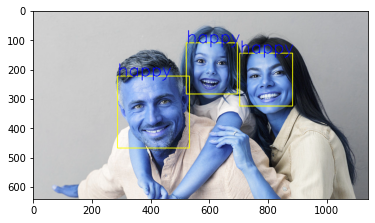

In [ ]:
img = cv2.imread(test_image)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for i,(x,y,w,h) in enumerate(faces):
        # To draw a rectangle in a face 
  cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,0),2) 
  roi_gray = gray[y:y+h, x:x+w]
  roi_color = img[y:y+h, x:x+w]
  
        # Detects eyes of different sizes in the input image
  eyes = eye_cascade.detectMultiScale(roi_gray) 
  cv2.putText(img,str(expression[i]),(x,y),cv2.FONT_HERSHEY_SIMPLEX,2,(0, 0, 255),2)

plt.imshow(img)